### Ejercicio de clasificación con Regresión Logística
* Conjunto de datos: [Detección de spam](https://www.kaggle.com/datasets/wanderfj/enron-spam)

##### Preparación

In [1]:
# Importar librerías de análisis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Definir un tema para graficar
sns.set_style('whitegrid')

In [3]:
# Importar librerías de manejo de texto
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [16]:
# Descargar complementos de NLTK
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [4]:
# Iniciar instancias de stopwords y lematizador 
stop_words = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

In [5]:
# Crear función de limpieza del texto
def limpiar_texto(df, col, clean_col):

    # Eliminar la primera palabra
    df[clean_col] = df[col].apply(lambda x: x.split(' ', 1)[1])

    # Convertir en minúsculas y eliminar espacios en ambos lados
    df[clean_col] = df[clean_col].apply(lambda x: x.lower().strip())

    # Eliminar espacios extra dentro del texto
    df[clean_col] = df[clean_col].apply(lambda x: re.sub(' +', ' ', x))

    # Eliminar puntuación
    df[clean_col] = df[clean_col].apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))

    # Eliminar stopwords y obtener la raíz
    df[clean_col] = df[clean_col].apply(lambda x: ' '.join(lemma.lemmatize(text, 'v') for text in x.split() if text not in stop_words))

    return df

In [6]:
# Crear función para dibujar una nube de palabras
def nube_palabras(texto):
    
    # Crear la cadena de palabras
    text = " ".join(x for x in texto)
    
    # Crear la nube de palabras
    wordcloud = WordCloud(max_font_size=50, max_words=250, background_color='white').generate(text)

    # Graficar la imagen generada
    plt.figure(figsize=[10,12])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

##### Preprocesamiento

In [7]:
# Abrir el archivo
df = pd.read_csv('spam_enron1.csv', header=0, sep=',', usecols=['label','text','label_num'])
df.shape

(5171, 3)

In [8]:
# Ver las primeras filas
df.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [9]:
# Ver la información del conjunto de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      5171 non-null   object
 1   text       5171 non-null   object
 2   label_num  5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [10]:
# Contar el número de valores nulos por variable
df.isna().sum()

label        0
text         0
label_num    0
dtype: int64

In [11]:
# Ver el conteo por clase
df['label'].value_counts()

ham     3672
spam    1499
Name: label, dtype: int64

Diferencia entre Stemming y Lemmatization:
* **Stemming**: Proceso que elimina los últimos caracteres de una palabra, llevando a erroes de ortografía y significado. Es usado para grandes conjuntos de datos donde el rendimiento es importante.
* **Lemmatization**: Proceso que convierte una palabra a su raíz (o lema) mediante el contexto. Es preferible para conjuntos de datos ligeros por ser más costoso computacionalmente.

In [12]:
# Aplicar el preprocesamiento de texto
limpiar_texto(df, 'text', 'texto_limpio')
df['length'] = df['texto_limpio'].str.len()
df.head()

,label,text,label_num,texto_limpio,length
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0,enron methanol meter follow note give monday p...,205
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0,hpl nom january see attach file hplnol xls hpl...,53
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0,neon retreat ho ho ho around wonderful time ye...,1340
3,spam,"Subject: photoshop , windows , office . cheap ...",1,photoshop windows office cheap main trend abas...,372
4,ham,Subject: re : indian springs\r\nthis deal is t...,0,indian spring deal book teco pvr revenue under...,173


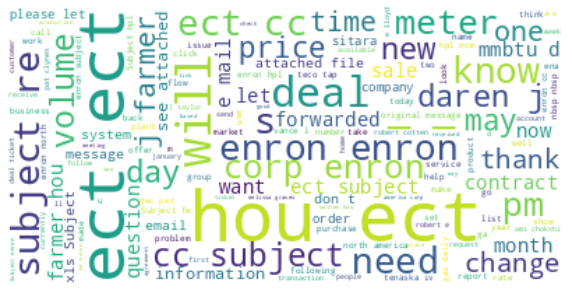

In [13]:
# Dibujar una nube de palabras
nube_palabras(df['text'])

In [14]:
# Vectorizar el texto con TF-IDF y BoW
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=2)
BOW = vectorizer.fit_transform(df['texto_limpio'])
palabras = vectorizer.get_feature_names_out()

In [15]:
# Separar en características (X) y etiquetas (Y)
X = pd.DataFrame(BOW.todense(), index=df.index, columns=palabras)
y = df['label_num']

In [16]:
# Dividir en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=99)
X_train.shape[0], X_test.shape[0]

(4136, 1035)

##### Ajustar el modelo de regresión logística

In [17]:
# Definir una malla de parámetros
param_grid = {
    'C': 1 / np.logspace(-5, 5, 50),
    'penalty': ['l1', 'l2']
}

In [18]:
# Buscar los mejores hiperparámetros
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(solver='liblinear', random_state=99)
grid = GridSearchCV(clf, param_grid, cv=5, scoring='average_precision', n_jobs=-1, verbose=0, return_train_score=True)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(random_state=99, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e+05, 6.25055193e+04, 3.90693994e+04, 2.44205309e+04,
       1.52641797e+04, 9.54095476e+03, 5.96362332e+03, 3.72759372e+03,
       2.32995181e+03, 1.45634848e+03, 9.10298178e+02, 5.68986603e+02,
       3.55648031e+02, 2.22299648e+02, 1.38949549e+02, 8.6851137...
       1.93069773e-01, 1.20679264e-01, 7.54312006e-02, 4.71486636e-02,
       2.94705170e-02, 1.84206997e-02, 1.15139540e-02, 7.19685673e-03,
       4.49843267e-03, 2.81176870e-03, 1.75751062e-03, 1.09854114e-03,
       6.86648845e-04, 4.29193426e-04, 2.68269580e-04, 1.67683294e-04,
       1.04811313e-04, 6.55128557e-05, 4.09491506e-05, 2.55954792e-05,
       1.59985872e-05, 1.00000000e-05]),
                         'penalty': ['l1', 'l2']},
             return_train_score=True, scoring='average_precision')

In [19]:
# Ver el resultado del mejor modelo
print('Precisión: %.2f%%' % (grid.best_score_*100))
print(grid.best_params_)

Precisión: 99.60%
{'C': 86.8511373751352, 'penalty': 'l2'}


In [20]:
# Entrenar el modelo
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(penalty='l2', C=86.8511373751352, solver='liblinear', max_iter=250, random_state=99)
clf.fit(X_train, y_train)

LogisticRegression(C=86.8511373751352, max_iter=250, random_state=99,
                   solver='liblinear')

In [21]:
# Evaluar el modelo
from sklearn.metrics import accuracy_score, balanced_accuracy_score

y_pred = clf.predict(X_test)
print('Precisión: %.2f%%' % (accuracy_score(y_test, y_pred)*100))
print('Precisión balanceada: %.2f%%' % (balanced_accuracy_score(y_test, y_pred)*100))

Precisión: 98.74%
Precisión balanceada: 98.73%


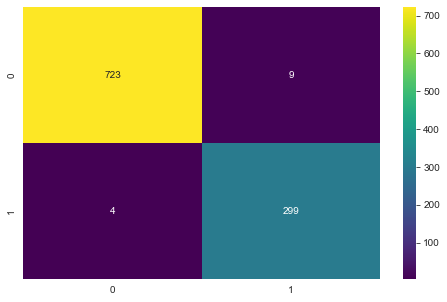

In [22]:
# Crear la matriz de confusión
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.heatmap(cm, annot=True, fmt='g', cmap='viridis')
plt.show()

c:\Users\frpm0\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


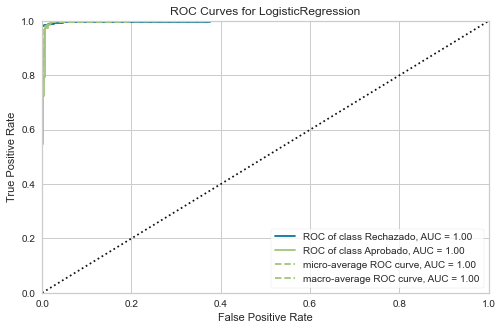

In [23]:
# Graficar la curva ROC
from yellowbrick import ROCAUC

fig, ax = plt.subplots(figsize=(8, 5))
visualizer = ROCAUC(clf, classes=['Rechazado', 'Aprobado'], ax=ax)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show();